In [1]:
from VIPurPCAvsMC import *
import jax.numpy as np
import jax
from jax import jacrev, vmap

from sklearn.decomposition import PCA
from utils import *
import seaborn as sns
import time

import matplotlib.pyplot as plt
from matplotlib import rcParams

cm = 1 / 2.54
plt.rc('font', size=8)
plt.rc('xtick', labelsize=6)
plt.rc('ytick', labelsize=6)
plt.rc('axes', labelsize=8)
rcParams['font.family'] = "sans-serif"
rcParams['font.sans-serif'] = "Helvetica"

In [2]:
n=20
p=100
X, y = make_blobs(n_samples=n, n_features=p, centers=4, random_state=2, shuffle=False, cluster_std=5)
B = 1*make_spd_matrix(p, random_state=27)
A = 1*make_spd_matrix(n, random_state=27)
X = scipy.stats.matrix_normal.rvs(mean=X, rowcov=A, colcov=B, size=1, random_state=27) 
scale_values = np.diag(np.array([i for i in range(1, p+1)]))
#X = X.dot(scale_values)
# center X
X = X - np.mean(X, axis=0)
X_flat, X_unflattener = flatten_util.ravel_pytree(X)
p_keep = 2

In [3]:
# VIPurPCA
V = pca(X_flat, X_unflattener, p_keep)
f = lambda X: pca(X, X_unflattener, p_keep)
_, f_vjp = vjp(f, X_flat)
_, f_jvp = jax.linearize(f, X_flat)
cvp_fun = lambda s: cvp(f_jvp, f_vjp, X_flat, X_unflattener, A, B, n, p, p_keep, s)
#C = np.array([cvp_fun(i) for i in range(min(n, p_keep)*p)])
#C = map(cvp_fun, np.arange(min(n, p_keep)*p))
#C = map(cvp_fun, np.arange(1))
batch_size = 1000
b = batch(np.arange(min(n, p_keep)*p), batch_size)
C = np.vstack([vmap(cvp_fun)(i) for i in b])

In [4]:
n_iter = 1000
key = jax.random.PRNGKey(42)
V_drawn = jax.random.multivariate_normal(key, V, C+1e-5*np.eye(V.shape[0]), shape=(n_iter,))
T_s = np.array([X @ np.transpose(np.reshape(i, (min(n, p_keep), p), 'C')) for i in V_drawn])
pca_mean_T = X@np.transpose(np.reshape(V, (min(n, p_keep), p), 'C'))

In [5]:
cmaps = ['Blues', 'Greens', 'Reds', 'Purples']

Text(0.5, 0, 'PC 1')

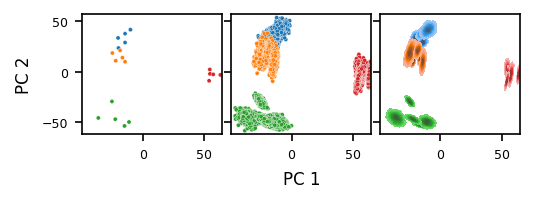

In [6]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(8.61*cm, 3*cm), tight_layout = {'pad': 0.1})
pcx, pcy = (0, 1)
sns.scatterplot(x=pca_mean_T[:, 0], y=pca_mean_T[:, 1], s=4, c=[plt.cm.tab10(j) for j in y], ax=ax1)
for j in range(n):
    sns.scatterplot(x=T_s[:, j, pcx], y=T_s[:, j, pcy], s=4, c=[plt.cm.tab10(y[j]) for i in range(n_iter)], ax=ax2)#, label=list(d.columns.values)[j], c=['C'+str(labels[j]) for i in range(n_iter)])#, marker=m[labels2[j]], alpha=.5)
    #ax2.scatter(x=T_mcs[:, j, pcx], y=T_mcs[:, j, pcy], s=5)
    sns.kdeplot(x=T_s[:, j, pcx], y=T_s[:, j, pcy], shade=True, ax=ax3, color=plt.cm.tab10(y[j]))
    #ax2.set_title('kde VIPurPCA')
ax1.set_ylabel('PC 2')
ax2.set_xlabel('PC 1')


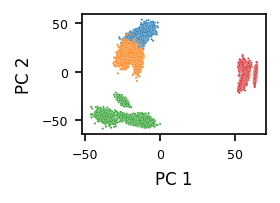

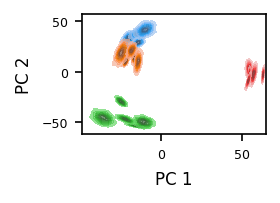

In [13]:
fig1, ax1 = plt.subplots(1, 1, figsize=(4.3*cm, 3*cm), tight_layout = {'pad': 0.1})
fig2, ax2 = plt.subplots(1, 1, figsize=(4.3*cm, 3*cm), tight_layout = {'pad': 0.1})
pcx, pcy = (0, 1)
#sns.scatterplot(x=pca_mean_T[:, 0], y=pca_mean_T[:, 1], s=4, c=[plt.cm.tab10(j) for j in y], ax=ax1)
for j in range(n):
    sns.scatterplot(x=T_s[:, j, pcx], y=T_s[:, j, pcy], s=1, c=[plt.cm.tab10(y[j]) for i in range(n_iter)], ax=ax1)#, label=list(d.columns.values)[j], c=['C'+str(labels[j]) for i in range(n_iter)])#, marker=m[labels2[j]], alpha=.5)
    #ax2.scatter(x=T_mcs[:, j, pcx], y=T_mcs[:, j, pcy], s=5)
    sns.kdeplot(x=T_s[:, j, pcx], y=T_s[:, j, pcy], shade=True, ax=ax2, color=plt.cm.tab10(y[j]), alpha=0.7)
    #ax2.set_title('kde VIPurPCA')
ax1.set_ylabel('PC 2')
ax1.set_xlabel('PC 1')
ax2.set_xlabel('PC 1')
ax2.set_ylabel('PC 2')
fig1.tight_layout()
fig2.tight_layout()
fig1.savefig('../results/vis_evaluation/overlayview.pdf')
fig2.savefig('../results/vis_evaluation/kde.pdf')

In [7]:
n_samples = 10
S = equipotential_standard_normal(V.shape[0], n_samples+1)
L, lower = jax.scipy.linalg.cho_factor(C+1e-5*np.eye(V.shape[0]), lower=True)
#M_flat, M_unflattener = flatten_util.ravel_pytree(M)
eigv_samples = np.transpose(np.dot(L, S))+V
samples_reshaped = vmap(lambda s: np.transpose(np.reshape(s, (min(n, p_keep), p), 'C')))(eigv_samples)

/home/zabel/vipurpca/src/utils.py:87: RuntimeWarning: invalid value encountered in true_divide
  M = np.dot(mu, np.expand_dims(np.cos(theta), axis=0)) + E * np.sin(theta) / theta


In [8]:
V.shape

(200,)

In [20]:
samples = np.array([X @ i for i in samples_reshaped])

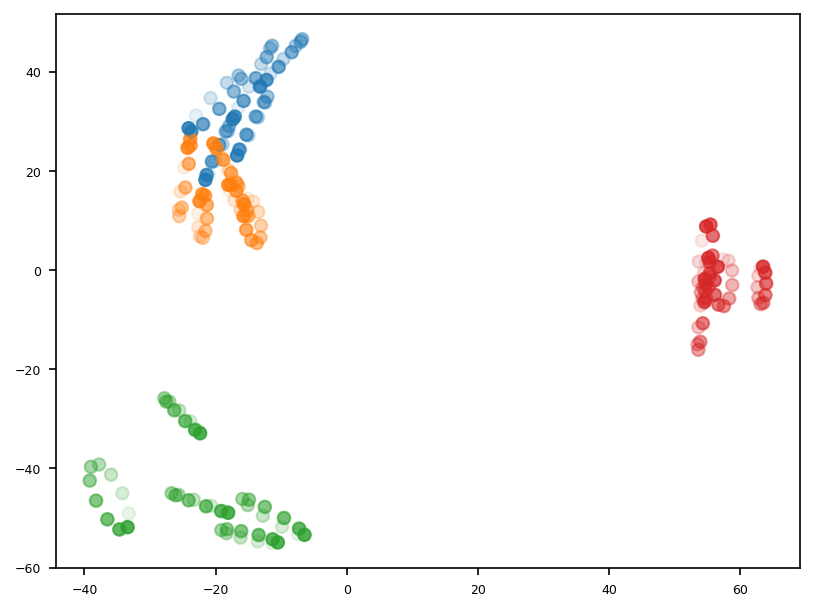

In [21]:
from matplotlib.lines import Line2D
fig, ax = plt.subplots(1)
for j, sample in enumerate(samples):
    ax.scatter(sample[:, 0], sample[:, 1], c=[plt.cm.tab10(j) for j in y], 
               alpha=[i for i in np.arange(0.1, 1, 0.08)][j])
               #marker=list(Line2D.markers.keys())[j])

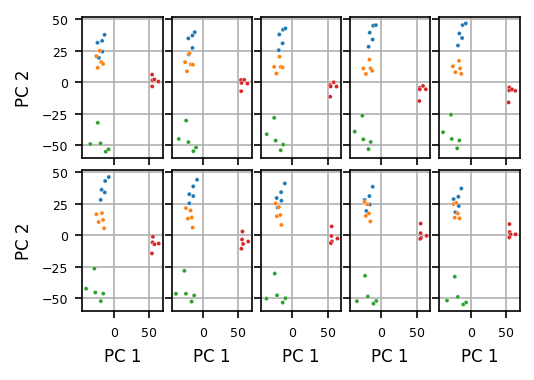

In [25]:
fig, axes = plt.subplots(2, 5, figsize=(8.6*cm, 6*cm), sharex=True, sharey=True, tight_layout = {'pad': 0.1})
ax_list = axes.ravel()
for ax in ax_list:
    ax.set_axisbelow(True)
    ax.grid(True)
for j, sample in enumerate(samples):
    sns.scatterplot(x=sample[:, 0], y=sample[:, 1], s=4, c=[plt.cm.tab10(j) for j in y], ax=ax_list[j]) 
    ax_list[j].set_xlabel('PC 1')
    ax_list[j].set_ylabel('PC 2')
for ax in ax_list:
    ax.label_outer()
plt.tight_layout()
plt.savefig('../results/vis_evaluation/smallmultiples.pdf')

-60.6135986328125 70.3361972808838


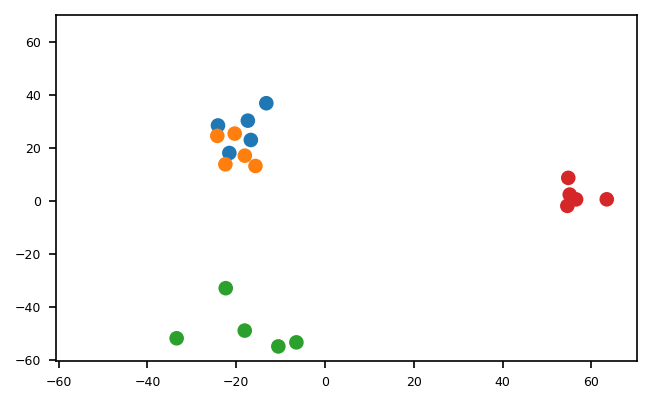

In [23]:
from matplotlib.animation import FuncAnimation, PillowWriter, FFMpegWriter
fig, ax = plt.subplots(figsize=(5, 3))
sample_0 = samples[0]
labels=y
#sample_0 = sample_0.reshape((len(labels), 2))
minimum = np.min(samples)+0.1*np.min(samples)
maximum = np.max(samples)+0.1*np.max(samples)
print(minimum, maximum)
scat = ax.scatter(sample_0[:, 0], sample_0[:, 1], c=[plt.cm.tab10(j) for j in y])#, cmap='tab10')
ax.set_xlim((minimum, maximum))
ax.set_ylim((minimum, maximum))
#scat, = ax.plot([], [], 'o')
def init():
    #scat.set_data([], [])
    #plt.scatter(mean[:, 0], mean[:, 1], c='black')
    return scat,

def animate(i):
    sample_i = samples[i]
    #sample_i = sample_i.reshape((len(labels), 2))
    #scat.set_data(sample_i[:, 0], sample_i[:, 1])
    scat.set_offsets(sample_i)
    return scat, 

anim = FuncAnimation(
    fig, animate, interval=1000, frames=n_samples, blit=True, init_func=init)

anim.save("../results/vis_evaluation/animation.gif", dpi=150, writer=PillowWriter(fps=5))

In [9]:
V

DeviceArray([-0.10726056,  0.01239242, -0.07088907,  0.01525568,
              0.07648116,  0.0054907 , -0.0054353 , -0.17579629,
             -0.13133353,  0.1124651 ,  0.02594958, -0.1876143 ,
              0.20356819,  0.05214943,  0.08420669, -0.15256846,
             -0.07255141,  0.13510633,  0.04146098,  0.03115039,
             -0.23883903, -0.01759228,  0.13010016,  0.08017198,
              0.12670942, -0.08384925,  0.03220909, -0.05785418,
             -0.06703793, -0.04391116, -0.08017164, -0.06134414,
             -0.05162958,  0.11430082, -0.08972871,  0.09408562,
             -0.17142045, -0.05097561,  0.06056543, -0.05649289,
             -0.06503583, -0.04808326, -0.18008624, -0.03290152,
              0.04696795,  0.01797641, -0.12096219,  0.13055173,
             -0.1102904 , -0.03926147,  0.11872444, -0.05741011,
              0.19257699,  0.12634797,  0.12294317,  0.22682455,
             -0.02017579,  0.01551902,  0.07972585, -0.13500722,
             -0.11025953,

In [13]:
np.ravel(np.transpose(np.reshape(V, (min(n, p_keep), p), 'C')), 'F')

array([-0.10726056,  0.01239242, -0.07088907,  0.01525568,  0.07648116,
        0.0054907 , -0.0054353 , -0.17579629, -0.13133353,  0.1124651 ,
        0.02594958, -0.1876143 ,  0.20356819,  0.05214943,  0.08420669,
       -0.15256846, -0.07255141,  0.13510633,  0.04146098,  0.03115039,
       -0.23883903, -0.01759228,  0.13010016,  0.08017198,  0.12670942,
       -0.08384925,  0.03220909, -0.05785418, -0.06703793, -0.04391116,
       -0.08017164, -0.06134414, -0.05162958,  0.11430082, -0.08972871,
        0.09408562, -0.17142045, -0.05097561,  0.06056543, -0.05649289,
       -0.06503583, -0.04808326, -0.18008624, -0.03290152,  0.04696795,
        0.01797641, -0.12096219,  0.13055173, -0.1102904 , -0.03926147,
        0.11872444, -0.05741011,  0.19257699,  0.12634797,  0.12294317,
        0.22682455, -0.02017579,  0.01551902,  0.07972585, -0.13500722,
       -0.11025953,  0.01126223, -0.01669309,  0.06367358,  0.05888277,
       -0.01028629, -0.10279553,  0.07882565, -0.08243429,  0.08